In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestRegressor
from sklearn.compose import TransformedTargetRegressor, ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import cross_validate
from sklearn.model_selection import TimeSeriesSplit, cross_val_predict
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
import joblib

In [3]:
header = pd.read_csv('../data/All_Data.csv', nrows=0, encoding='ISO-8859-1')
num_rows_to_read = 127081 - 70130 + 1
dataset = pd.read_csv(
    '../data/All_Data.csv', 
    skiprows=70129, 
    nrows=num_rows_to_read, 
    header=None, 
    names=header.columns, 
    encoding='ISO-8859-1', 
    low_memory=False
)

In [ ]:
dataset.loc[dataset["Event/Occasion"] == "None", "Event/Occasion"] = "No"
dataset["Event/Occasion"] = dataset["Event/Occasion"].astype("category").cat.remove_unused_categories()
dataset = dataset[dataset['Load (MW)'] > 0]
print("Minimum Load Value:", dataset['Load (MW)'].min())

Minimum Load Value: 2667.26


In [5]:
# Convert dates and sort
dataset['Date'] = pd.to_datetime(dataset['Date'], format='%d-%m-%Y')
dataset.sort_values(['Date', 'Time'], inplace=True)

In [6]:
# Date/time features
dataset['Date'] = pd.to_datetime(dataset['Date'], format='%d-%m-%Y')
dataset['Day'] = dataset['Date'].dt.day
dataset['Month'] = dataset['Date'].dt.month
dataset['Year'] = dataset['Date'].dt.year
dataset['Weekday'] = dataset['Date'].dt.weekday
dataset['DayOfYear'] = dataset['Date'].dt.dayofyear
dataset['Hour'] = dataset['Time'].str.split('-').str[0].str[:2].astype(int)
dataset.sort_values(['Date', 'Hour'], inplace=True)

In [7]:
def encode_cyclical(df, col, max_val):
    df[f'{col}_sin'] = np.sin(2 * np.pi * df[col]/max_val)
    df[f'{col}_cos'] = np.cos(2 * np.pi * df[col]/max_val)
    return df

time_features = [('Hour', 24), ('Weekday', 7), ('Month', 12), ('DayOfYear', 365)]
for col, max_val in time_features:
    dataset = encode_cyclical(dataset, col, max_val)

In [8]:
lags = [1, 6, 24, 168]
for lag in lags:
    dataset[f'load_lag_{lag}h'] = dataset['Load (MW)'].shift(lag)
    
dataset['7d_ma_load'] = dataset['Load (MW)'].rolling(168).mean()
dataset['temp_x_hour'] = dataset['Temperature (°C)'] * dataset['Hour']

# Final cleaning
dataset.dropna(inplace=True)

In [9]:
cyclical_cols = [f'{col}_{trig}' for col, _ in time_features for trig in ['sin', 'cos']]
categorical_features = ['Condition', 'Holiday', 'Event/Occasion']
numerical_features = [
    'Temperature (°C)', 'Humidity (%)', 'Wind Speed (m/s)',
    'Rainfall (mm)', 'Solar Generation', 'low_price', 'high_price',
    'Average_Price_Rs_Per_Sqft', 'QoQ_Price_Change_Percent(%)',
    'load_lag_1h', 'load_lag_6h', 'load_lag_24h', 'load_lag_168h',
    '7d_ma_load', 'temp_x_hour'
]

In [10]:
X = dataset.drop(columns=['Load (MW)', 'Date', 'Time'])
y = dataset['Load (MW)']

In [ ]:
preprocessor = ColumnTransformer([
    ('cat', OneHotEncoder(handle_unknown='infrequent_if_exist', sparse_output=False), 
     categorical_features),
    ('num', 'passthrough', numerical_features + cyclical_cols)
])

In [12]:
final_model = Pipeline([
    ('preprocessor', preprocessor),
    ('model', TransformedTargetRegressor(
        regressor=RandomForestRegressor(
            n_estimators=200,
            max_depth=15,
            min_samples_split=10,
            max_features=0.7,
            max_samples=0.8,
            random_state=42,
            n_jobs=-1
        ),
        func=np.log,
        inverse_func=np.exp
    ))
])

In [13]:
final_model.fit(X, y)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('cat',
                                                  OneHotEncoder(handle_unknown='infrequent_if_exist',
                                                                sparse_output=False),
                                                  ['Condition', 'Holiday',
                                                   'Event/Occasion']),
                                                 ('num', 'passthrough',
                                                  ['Temperature (°C)',
                                                   'Humidity (%)',
                                                   'Wind Speed (m/s)',
                                                   'Rainfall (mm)',
                                                   'Solar Generation',
                                                   'low_price', 'high_price',
                                                   'Average_Price_Rs_Per_Sqft',
                                                   'QoQ_Pri...
                                                   '7d_ma_load', 'temp_x_hour',
                                                   'Hour_sin', 'Hour_cos',
                                                   'Weekday_sin', 'Weekday_cos',
                                                   'Month_sin', 'Month_cos',
                                                   'DayOfYear_sin',
                                                   'DayOfYear_cos'])])),
                ('model',
                 TransformedTargetRegressor(func=<ufunc 'log'>,
                                            inverse_func=<ufunc 'exp'>,
                                            regressor=RandomForestRegressor(max_depth=15,
                                                                            max_features=0.7,
                                                                            max_samples=0.8,
                                                                            min_samples_split=10,
                                                                            n_estimators=200,
                                                                            n_jobs=-1,
                                                                            random_state=42)))])

In [23]:
joblib.dump(final_model, "../model.pkl")

['../model.pkl']

In [ ]:
# 1. Cross-Validation Metrics
cv_results = cross_validate(
    final_model,
    X, y,
    cv=5,
    scoring=['neg_mean_squared_error', 'neg_mean_absolute_error', 'r2'],
    n_jobs=-1,
    return_train_score=True
)

print(f"Average CV RMSE: {np.sqrt(-cv_results['test_neg_mean_squared_error']).mean():.2f}")
print(f"Average CV MAE: {-cv_results['test_neg_mean_absolute_error'].mean():.2f}")
print(f"Average CV R²: {cv_results['test_r2'].mean():.2f}")

# Compare train vs validation scores
print(f"\nTrain R²: {cv_results['train_r2'].mean():.2f} vs Validation R²: {cv_results['test_r2'].mean():.2f}")

Average CV RMSE: 2308.80
Average CV MAE: 1158.84
Average CV R²: 0.97

Train R²: 0.99 vs Validation R²: 0.97


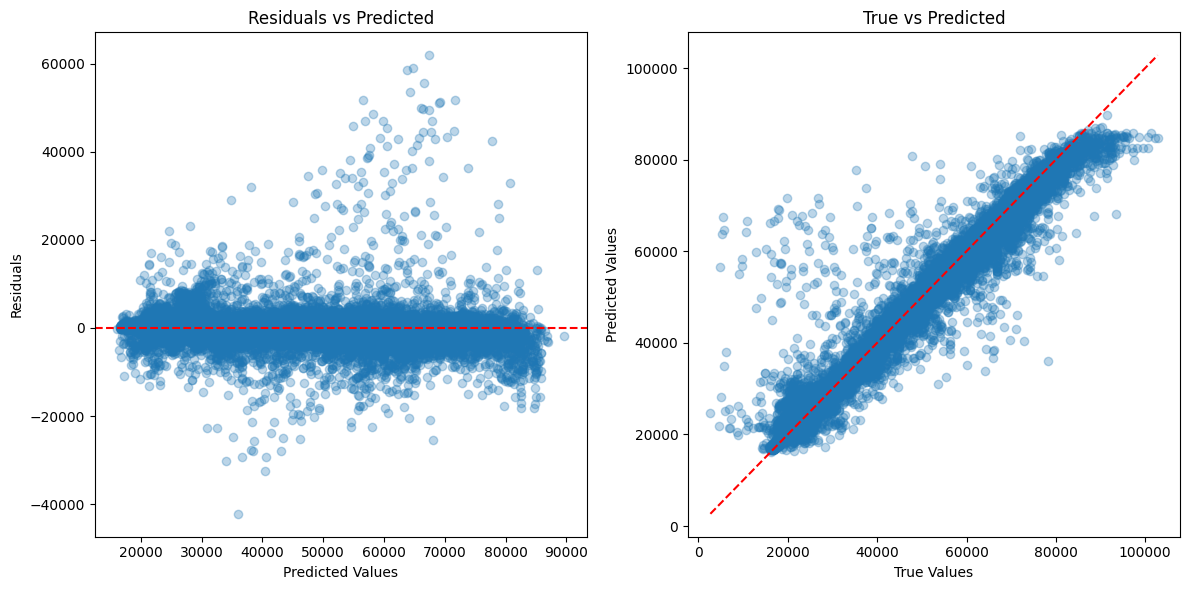

In [ ]:
# 2. Residual Analysis
# Get cross-validated predictions
y_pred = cross_val_predict(final_model, X, y, cv=5, n_jobs=-1)

# Residual plots
plt.figure(figsize=(12, 6))

# Residuals vs Predicted
plt.subplot(1, 2, 1)
plt.scatter(y_pred, y_pred - y, alpha=0.3)
plt.xlabel("Predicted Values")
plt.ylabel("Residuals")
plt.axhline(0, color='red', linestyle='--')
plt.title("Residuals vs Predicted")

# Prediction accuracy
plt.subplot(1, 2, 2)
plt.scatter(y, y_pred, alpha=0.3)
plt.plot([y.min(), y.max()], [y.min(), y.max()], 'r--')
plt.xlabel("True Values")
plt.ylabel("Predicted Values")
plt.title("True vs Predicted")

plt.tight_layout()
plt.show()

In [ ]:
# 3. Temporal Validation
# If your data has time dependency
from sklearn.model_selection import TimeSeriesSplit

# Assuming data is sorted by date
tscv = TimeSeriesSplit(n_splits=5)
time_cv_scores = cross_validate(
    final_model,
    X, y,
    cv=tscv,
    scoring=['neg_mean_squared_error', 'r2'],
    n_jobs=-1
)

print(f"Time Series CV RMSE: {np.sqrt(-time_cv_scores['test_neg_mean_squared_error'])}")
print(f"Time Series R²: {time_cv_scores['test_r2']}")

Time Series CV RMSE: [1318.70008811 1534.05934092 2783.96189193 3412.81527127 4117.87284348]
Time Series R²: [0.99199181 0.98557684 0.95369856 0.94717081 0.94126157]


In [20]:
# 4. Feature Importance Validation
feature_names = final_model.named_steps['preprocessor'].get_feature_names_out()
importances = final_model.named_steps['model'].regressor_.feature_importances_

print("=== Top 10 Features ===")
top_features = pd.Series(importances, index=feature_names).sort_values(ascending=False).head(10)
print(top_features)

=== Top 10 Features ===
num__load_lag_1h         0.635624
num__load_lag_24h        0.273675
num__7d_ma_load          0.028225
num__load_lag_168h       0.014577
num__Hour_cos            0.012283
num__temp_x_hour         0.010147
num__Hour_sin            0.004690
num__Temperature (°C)    0.004472
num__load_lag_6h         0.003935
num__DayOfYear_cos       0.002602
dtype: float64


In [21]:
# 5. Business Logic Checks
print("=== Business Validation ===")
# Check negative predictions
predictions = final_model.predict(X)
print(f"Negative Predictions: {(predictions < 0).sum()} (should be 0)")

# Sample inspection
sample = X.sample(5)
print("\nSample Predictions:")
print(pd.DataFrame({
    'Predicted': final_model.predict(sample),
    'Actual': y.loc[sample.index],
    'Difference (%)': np.abs((final_model.predict(sample) - y.loc[sample.index])/y.loc[sample.index])*100
}))

=== Business Validation ===
Negative Predictions: 0 (should be 0)

Sample Predictions:
          Predicted    Actual  Difference (%)
55206  43280.401114  44828.02        3.452347
10858  43099.878584  43850.37        1.711483
19568  26764.467817  27047.95        1.048073
12679  53665.613392  53548.36        0.218967
28633  35003.007377  34740.88        0.754521


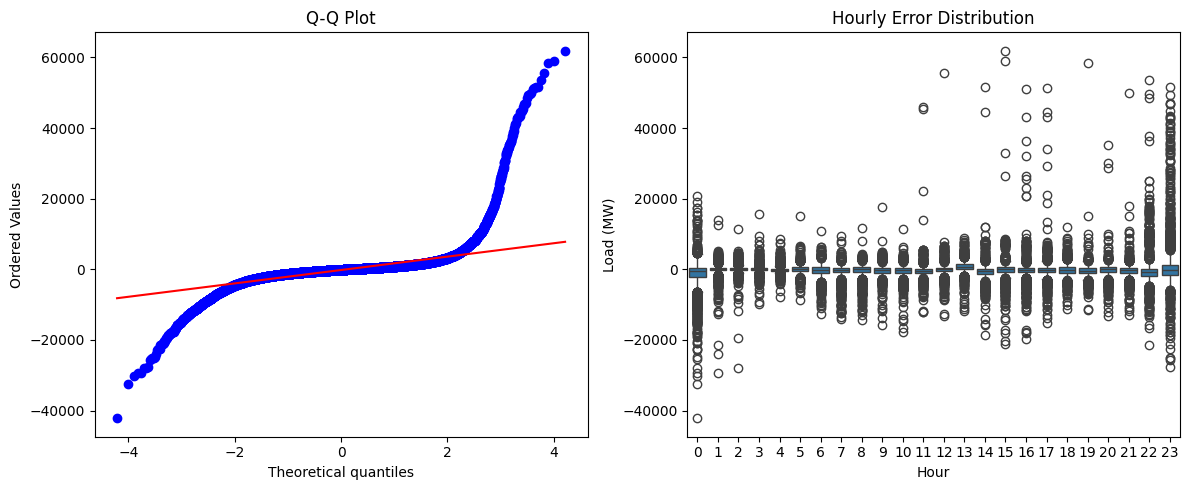

In [22]:
# 6. Error Distribution Analysis
from scipy import stats
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
stats.probplot(y_pred - y, dist="norm", plot=plt)
plt.title('Q-Q Plot')

plt.subplot(1, 2, 2)
sns.boxplot(x=dataset['Hour'], y=y_pred - y)
plt.title('Hourly Error Distribution')
plt.tight_layout()
plt.show()